# Разведочный анализ датасета

Разведочный анализ данных (англ. exploratory data analysis, EDA) — анализ основных свойств данных, нахождение в них общих закономерностей, распределений и аномалий, построение начальных моделей, зачастую с использованием инструментов визуализации.

В данной лабораторной работе был проведён разведочный анализ датасета, содержащего данные о поездках на велосипедах от компании Cyclistics, занимающейся арендой велосипедов. 

Используемый датасет: https://www.kaggle.com/datasets/sarfarazmulla/google-data-analytics-capstone-cyclistic

## Подготовка и импорты

Для одного из графиков используется карта местности, для отображения которой требуется geopandas

In [1]:
%%capture
%pip install geopandas

Слеудющие модули не относятся к PySpark, но будут использованы в процессе анализа датасета

In [2]:
# Disable warnings from pandas that are caused by pyspark
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import other modules not related to PySpark
import os
import sys

from datetime import *
from dateutil.parser import parse

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

# Plots and charts
%matplotlib inline
sns.set_style()
sns.set()

pastel = sns.color_palette('pastel')
muted = sns.color_palette('muted')

Эти модули являются частью библиотеки PySpark и используются для взаимодействия с движком Spark

In [3]:
# Import PySpark related modules
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit, col, isnan, udf, when
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.ml import Estimator, Transformer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

Настройка Spark и получение объекта сессии

In [4]:
# Initialize a spark session.
MAX_MEMORY = '4G'

conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

## Подготовка данных

Объявление схемы и чтение файла

In [5]:
filename_data = 'data/tripdata.csv'

schema = StructType([
    StructField('_c0', IntegerType(), True),
    StructField('ride_id', StringType(), True),
    StructField('bike_type', StringType(), True),
    StructField('start_date', StringType(), True),
    StructField('end_date', StringType(), True),
    StructField('start_station_name', StringType(), True),
    StructField('start_station_id', StringType(), True),
    StructField('end_station_name', StringType(), True),
    StructField('end_station_id', StringType(), True),
    StructField('start_lat', DoubleType(), True),
    StructField('start_lng', DoubleType(), True),
    StructField('end_lat', DoubleType(), True),
    StructField('end_lng', DoubleType(), True),
    StructField('member_casual', StringType(), True),
    StructField('duration', StringType(), True),
    StructField('day_of_week', StringType(), True),
    StructField('month', StringType(), True),
    StructField('distance', DoubleType(), True),
])

df = spark.read.schema(schema).csv(filename_data, header=True).drop('_c0')

Датасет состоит из следующих столбцов:

- ride_id - уникальный идентификатор поездки
- bike_type - тип велосипеда
- start_date и end_date - временные метки начала и окончания поездки
- start_station_name и end_station_name - названия начальной и конечной станции
- start_station_id и end_station_id - идентификаторы начальной и конечной станции
- start_lat, start_lng, end_lat и end_lng - координаты точек начала и окончания поездки
- member_casual - имеет ли пользователь членство компании Cyclistics
- duration - длительность поездки
- day_of_week, month - день недели и месяц, когда была совершена поездка
- distance - расстояние между начальной и конечной точками

In [6]:
df.limit(5).toPandas()

,ride_id,bike_type,start_date,end_date,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,day_of_week,month,distance
0,7C660BB0C4949ABC,classic_bike,2021-08-23 18:47:03,2021-08-23 19:00:08,Clark St & Wrightwood Ave,TA1305000014,Southport Ave & Clybourn Ave,TA1309000030,41.929546,-87.643118,41.920771,-87.663712,member,0:13:05,Monday,August,1963.381209
1,FE73183E7F2B55D2,classic_bike,2021-08-17 18:04:40,2021-08-17 18:34:11,Clark St & Wrightwood Ave,TA1305000014,DuSable Lake Shore Dr & Monroe St,13300,41.929546,-87.643118,41.880958,-87.616743,member,0:29:31,Tuesday,August,5826.986286
2,121289DD4E7C56DE,docked_bike,2021-08-11 16:52:15,2021-08-11 17:21:23,Halsted St & Polk St,TA1307000121,Wallace St & 35th St,TA1308000045,41.871840,-87.646640,41.830629,-87.641290,casual,0:29:08,Wednesday,August,4603.825441
3,EDD8BE43E39C14A2,classic_bike,2021-08-08 17:09:02,2021-08-08 17:33:43,900 W Harrison St,13028,DuSable Lake Shore Dr & Monroe St,13300,41.874754,-87.649807,41.880958,-87.616743,casual,0:24:41,Sunday,August,2823.031438
4,E47F8C8A242BA089,classic_bike,2021-08-26 18:37:23,2021-08-26 18:54:28,Morgan St & Polk St,TA1307000130,DuSable Lake Shore Dr & Monroe St,13300,41.871737,-87.651030,41.880958,-87.616743,casual,0:17:05,Thursday,August,3018.261016


Получим обзорные статистики по каждой из колонок

In [7]:
df.describe().toPandas()

,summary,ride_id,bike_type,start_date,end_date,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,day_of_week,month,distance
0,count,5901044,5901044,5901044,5901044,5040284,5040286,4981382,4981382,5901044,5901044,5895454,5895454,5901044,5901044,5901044,5901044,5901044
1,mean,Infinity,None,None,None,351.0,12460.295613189059,None,12522.998857156143,41.900768479881606,-87.64742205707789,41.90102103858501,-87.64760841946536,None,None,None,None,11455.262955632648
2,stddev,NaN,None,None,None,0.0,7497.373639072129,None,7563.218453559967,0.04725636724911936,0.030938997541463977,0.04734829568439617,0.0305654627672688,None,None,None,None,301802.91674231284
3,min,00000123F60251E6,classic_bike,01/04/2022 00:01:48,01/04/2022 00:02:15,"""Senka """"Edward Duke"""" Park""",1011,"""Senka """"Edward Duke"""" Park""",1011,41.64,-87.84,41.39,-88.97,casual,#REF!,Friday,April,0.0
4,max,FFFFFF1C07792282,electric_bike,30/04/2022 23:59:54,30/04/2022 23:59:57,Zapata Academy,chargingstx5,Zapata Academy,chargingstx5,45.63503432,-73.79647696,42.37,-87.5,member,9:59:59,Wednesday,September,9823369.411


Можно заметить, что в столбцах duration и distance встречаются нереалистичные значения (например, 9+ тыс. км.). Найдём строки с такими значениями

In [8]:
df.where(df.distance > 9000000).limit(5).toPandas()

,ride_id,bike_type,start_date,end_date,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,day_of_week,month,distance
0,55EB0B8B43DC0CF9,classic_bike,2021-08-22 12:19:30,2021-08-22 12:49:39,Burling St & Diversey Pkwy,TA1309000036,None,None,41.933140,-87.647760,NaN,NaN,member,0:30:09,Sunday,August,9812982.642
1,49CA15038F9D93DD,classic_bike,2021-08-15 20:24:17,2021-08-15 23:41:00,Halsted St & Wrightwood Ave,TA1309000061,None,None,41.929143,-87.649077,NaN,NaN,casual,3:16:43,Sunday,August,9813079.355
2,32A56CFD9619752A,classic_bike,2021-08-04 13:41:03,2021-08-05 14:40:59,Halsted St & 111th St,20127,None,None,41.692263,-87.642612,NaN,NaN,casual,24:59:56,Wednesday,August,9811822.071
3,51201D695268C599,classic_bike,2021-08-20 15:15:05,2021-08-21 16:14:57,Theater on the Lake,TA1308000001,None,None,41.926277,-87.630834,NaN,NaN,casual,24:59:52,Friday,August,9811561.952
4,3C798744DBA5656F,classic_bike,2021-08-22 12:53:17,2021-08-22 13:20:42,Theater on the Lake,TA1308000001,None,None,41.926277,-87.630834,NaN,NaN,casual,0:27:25,Sunday,August,9811561.952


Как видно, у таких поездок не указана точка назначения. Вероятно, это велосипеды, которые не были возвращены на станцию и, возможно, украдены. Определим количество строк с пропущенными значениями в каждой колонке

In [9]:
df.select([f.count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,ride_id,bike_type,start_date,end_date,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,day_of_week,month,distance
0,0,0,0,0,860760,860758,919662,919662,0,0,5590,5590,0,0,0,0,0


И удалим эти строки из датасета

In [10]:
df = df.dropna()

Также можно заметить, что даты в датасете указаны в нескольких форматах. Используем функцию `parse` из модуля `dateutil` для того чтобы преобразовать их к типу `Timestamp`. Для этого, объявим udf с соответствующим типом  результата. Также объявим функцию для преобразования времени в формате `hh:mm:ss` к числу секунд.

In [11]:
parse_date_udf = udf(parse, returnType=TimestampType())

@udf(returnType=IntegerType())
def get_total_seconds(time):
    h, m, s = time.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

И применим эти функции к соответствующим колонкам

In [12]:
df = df.withColumn('start_date', parse_date_udf('start_date')) \
       .withColumn('end_date', parse_date_udf('end_date')) \
       .withColumn('duration', get_total_seconds('duration'))

Посмотрим, что получилось

In [13]:
df.select("start_lat", "start_lng", "end_lat", "end_lng", "duration", "distance").describe().toPandas()

,summary,start_lat,start_lng,end_lat,end_lng,duration,distance
0,count,4629053,4629053,4629053,4629053,4629053,4629053
1,mean,41.90257810060474,-87.64433041470112,41.90286330888799,-87.64457389527288,1115.824882756797,2110.26820530563
2,stddev,0.04150126366706359,0.024994098451104636,0.041635399506594256,0.024377122544771136,5026.930084473847,1950.7612951168765
3,min,41.64850076,-87.83325417,41.64850076,-87.83,-6779,0.0
4,max,45.63503432,-73.79647696,42.16811567,-87.52740467,2497750,1189521.648


Отфильтруем строки с отрицательной или нулевой длительностью поездки

In [14]:
df = df.where(df.duration > 0)

Выглядит лучше, однако максимальное значение дистанции всё ещё больше 1 тыс. км. Найдём такие строки

In [15]:
df.where(df.distance > 1000000).limit(10).toPandas()

,ride_id,bike_type,start_date,end_date,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,day_of_week,month,distance
0,3327172413547F64,electric_bike,2022-01-14 11:13:15,2022-01-14 11:15:50,Pawel Bialowas - Test- PBSC charging station,Pawel Bialowas - Test- PBSC charging station,Pawel Bialowas - Test- PBSC charging station,Pawel Bialowas - Test- PBSC charging station,45.635034,-73.796477,41.8646,-87.681,casual,155,Friday,January,1189521.648


Судя по координатам, этот человек доехал от Монреаля до Чикаго, причём сделал это всего за 2.5 минуты. Вероятно, это тестовые данные, которые остались в базе данных компании.

Для удаления подобных выбросов, воспользуемся межквартильным расстоянием.

In [16]:
class RangeFilter(Transformer):
    def __init__(self, bounds):
        super().__init__()
        self.bounds = bounds
    
    def _transform(self, df):
        for c, (min_, max_) in self.bounds.items():
            df = df.where((col(c) >= min_) & (col(c) <= max_))
        return df

class InterquartileDistance(Estimator):
    def __init__(self, inputCols=(), coef=1.5, prec=0.05):
        super().__init__()
        self.inputCols = inputCols
        self.coef = coef
        self.prec = prec
        
    def _fit(self, df):
        bounds = {}
        for c in self.inputCols:
            q1, q3 = df.approxQuantile(c, [0.25, 0.75], self.prec)
            iqr = q3 - q1
            bounds[c] = q1 - iqr * self.coef, q3 + iqr * self.coef
        return RangeFilter(bounds)

In [17]:
df = InterquartileDistance(inputCols=['duration', 'distance']).fit(df).transform(df)

In [18]:
df.select('duration', 'distance').describe().toPandas()

,summary,duration,distance
0,count,4066918,4066918
1,mean,717.112921873517,1788.4576520259002
2,stddev,484.71316530615803,1215.9544353160509
3,min,1,0.0
4,max,2378,5392.1698


Можно заметить, что минимальным значением дистанции является 0, при этом поездка имеет адекватную длительность и начинается и заканчивается на одной и той же станции

In [19]:
df.where(df.distance == 0.0).limit(5).toPandas()

,ride_id,bike_type,start_date,end_date,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,day_of_week,month,distance
0,6FAE2B1E90A47A89,classic_bike,2021-08-02 16:17:20,2021-08-02 16:51:29,DuSable Lake Shore Dr & Monroe St,13300,DuSable Lake Shore Dr & Monroe St,13300,41.880958,-87.616743,41.880958,-87.616743,member,2049,Monday,August,0.0
1,81E856ED3E84D14C,docked_bike,2021-08-17 17:13:07,2021-08-17 17:48:42,Lakefront Trail & Bryn Mawr Ave,KA1504000152,Lakefront Trail & Bryn Mawr Ave,KA1504000152,41.984037,-87.652310,41.984037,-87.652310,casual,2135,Tuesday,August,0.0
2,7B7A1783BCEED824,docked_bike,2021-08-20 20:12:13,2021-08-20 20:47:14,DuSable Lake Shore Dr & Monroe St,13300,DuSable Lake Shore Dr & Monroe St,13300,41.880958,-87.616743,41.880958,-87.616743,casual,2101,Friday,August,0.0
3,F9BC9F150FC0801B,docked_bike,2021-08-06 18:44:06,2021-08-06 19:19:56,Lakefront Trail & Bryn Mawr Ave,KA1504000152,Lakefront Trail & Bryn Mawr Ave,KA1504000152,41.984037,-87.652310,41.984037,-87.652310,casual,2150,Friday,August,0.0
4,B1ED47C3EB106142,classic_bike,2021-08-19 07:51:00,2021-08-19 08:28:11,Lakefront Trail & Bryn Mawr Ave,KA1504000152,Lakefront Trail & Bryn Mawr Ave,KA1504000152,41.984037,-87.652310,41.984037,-87.652310,casual,2231,Thursday,August,0.0


Вынесем такие поездки в категорию "круговых"

In [20]:
df = df.withColumn('round_trip', when(df.distance == 0.0, 1).otherwise(0))

Также преобразуем колонки `bike_type` и `member_casual` в кодировку `one hot`. И удалим ненужные колонки

In [21]:
plot_df = df # Save becasue plots will use some columns that will be removed here

df = (
    df.withColumn('electric_bike', when(df.bike_type == 'electric_bike', 1).otherwise(0))
      .withColumn('docked_bike', when(df.bike_type == 'docked_bike', 1).otherwise(0))
      .withColumn('member', when(df.member_casual == 'member', 1).otherwise(0))
      .drop('bike_type', 'member_casual', 'ride_id', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id')
)

df.limit(5).toPandas()

,start_date,end_date,start_lat,start_lng,end_lat,end_lng,duration,day_of_week,month,distance,round_trip,electric_bike,docked_bike,member
0,2021-08-23 18:47:03,2021-08-23 19:00:08,41.929546,-87.643118,41.920771,-87.663712,785,Monday,August,1963.381209,0,0,0,1
1,2021-08-11 16:52:15,2021-08-11 17:21:23,41.871840,-87.646640,41.830629,-87.641290,1748,Wednesday,August,4603.825441,0,0,1,0
2,2021-08-08 17:09:02,2021-08-08 17:33:43,41.874754,-87.649807,41.880958,-87.616743,1481,Sunday,August,2823.031438,0,0,0,0
3,2021-08-26 18:37:23,2021-08-26 18:54:28,41.871737,-87.651030,41.880958,-87.616743,1025,Thursday,August,3018.261016,0,0,0,0
4,2021-08-21 10:20:20,2021-08-21 10:55:29,41.892278,-87.612043,41.880958,-87.616743,2109,Saturday,August,1317.484670,0,0,1,0


## Корреляции

Определим корреляции между значениями в датасете

In [22]:
cols = "start_lat", "start_lng", "end_lat", "end_lng", "duration", "distance" 
va = VectorAssembler(inputCols=cols, outputCol="num")
corr_df = va.transform(df).select('num')

corr = Correlation.corr(corr_df, 'num')

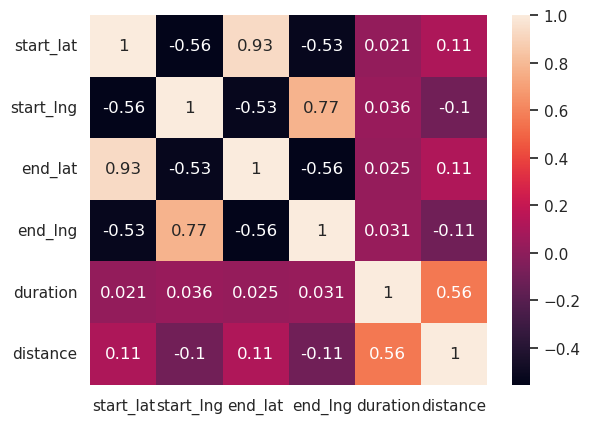

In [23]:
corr_mat = pd.DataFrame(corr.collect()[0][0].toArray(), columns=cols, index=cols)
_ = sns.heatmap(corr_mat, robust=True, annot=True)

По матрице корреляций видно, что координаты начала коррелируют с коордаинатами конца поедки, а длительность и расстояние c ними практически не коррелируют. При этом между собой расстояние и длительность имеют среднюю корреляцию.

## Графики и диаграммы

Ввиду большого размера датасета, целесообразно собрать и подготовить данные для построения графиков на стороне Spark. Подготовим данные для круговых диаграмм

In [24]:
round_trip = plot_df.groupBy(plot_df.round_trip).count().withColumn('round_trip', when(col('round_trip') == 1, 'round_trip').otherwise('one_way')).toPandas()
bike_type = plot_df.groupBy(plot_df.bike_type).count().toPandas()
member_casual = plot_df.groupBy(plot_df.member_casual).count().toPandas()

@udf(returnType=IntegerType())
def day_to_num(day):
    return {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3,
            'Thursday': 4, 'Friday': 5, 'Saturday': 6}[day.strip()]

@udf(returnType=IntegerType())
def month_to_num(month):
    return {'January': 0, 'February': 1, 'March': 2, 'April': 3, 'May': 4, 
            'June': 5, 'July': 6, 'August': 7, 'September': 8, 'October': 9, 
            'November': 10, 'December': 11}[month.strip()]

day_of_week = plot_df.groupBy(plot_df.day_of_week).count().withColumn('sort', day_to_num('day_of_week')).orderBy('sort').drop('sort').toPandas()
month = plot_df.groupBy(plot_df.month).count().withColumn('sort', month_to_num('month')).orderBy('sort').drop('sort').toPandas()

И построим соответствующие графики используя matplotlib

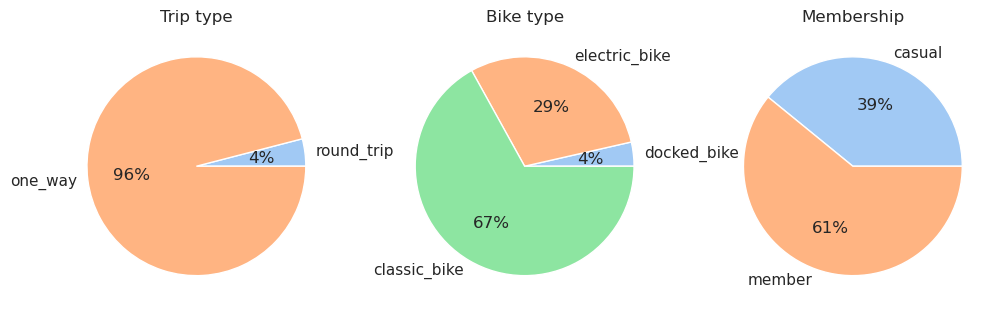

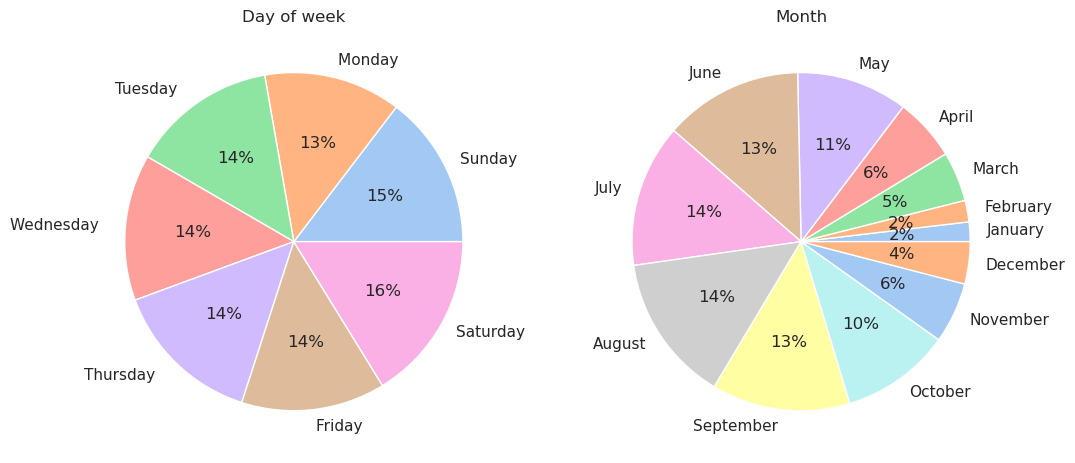

In [25]:
args = {'colors': pastel, 'autopct': '%.0f%%'}

figure, axes = plt.subplots(1, 3, squeeze=True, figsize=(12, 36))

axes[0].pie(round_trip['count'], labels=round_trip['round_trip'], **args)
axes[0].set_title('Trip type')

axes[1].pie(bike_type['count'], labels=bike_type['bike_type'], **args)
axes[1].set_title('Bike type')

axes[2].pie(member_casual['count'], labels=member_casual['member_casual'], **args)
axes[2].set_title('Membership')

figure, axes = plt.subplots(1, 2, squeeze=True, figsize=(12, 24))

axes[0].pie(day_of_week['count'], labels=day_of_week['day_of_week'], **args)
axes[0].set_title('Day of week')
axes[1].pie(month['count'], labels=month['month'], **args)
axes[1].set_title('Month');

---

Построим гистограмму распределения числа поездок по длительности

In [26]:
dist_hist = (
    plot_df.withColumn('hist', (plot_df.distance / 1000).astype(IntegerType()))
    .groupBy('hist').count().orderBy('hist')
    .withColumnRenamed('hist', 'distance').toPandas()
)

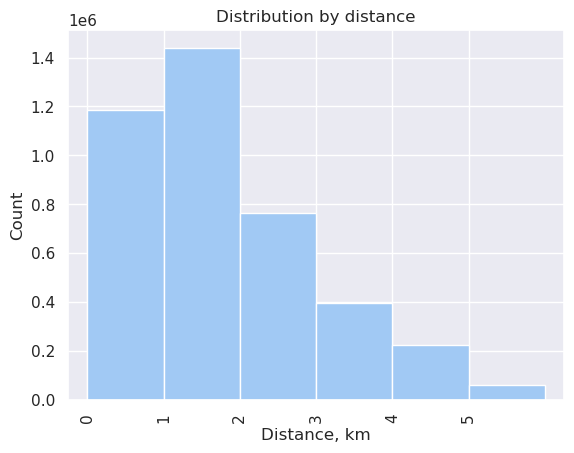

In [27]:
ax = dist_hist.plot.bar(
    x='distance', align='edge', width=1, 
    title='Distribution by distance',
    xlabel='Distance, km', ylabel='Count',
    color=pastel
)

ax.legend().remove()

Можно видеть, что большинство поездок приходится на расстояние нескольких километров, при этом их число распределено по показательному закону

---

Сгруппируем по типу велосипеда

In [28]:
with_hist = plot_df.withColumn('hist', (plot_df.distance / 1000).astype(IntegerType()))

classic = with_hist.where(with_hist.bike_type == 'classic_bike').groupBy('hist').count().orderBy('hist').withColumnRenamed('count', 'classic_bike')
electric = with_hist.where(with_hist.bike_type == 'electric_bike').groupBy('hist').count().orderBy('hist').withColumnRenamed('count', 'electric_bike')
docked = with_hist.where(with_hist.bike_type == 'docked_bike').groupBy('hist').count().orderBy('hist').withColumnRenamed('count', 'docked_bike')

dist_hist_2 = docked.join(electric, ['hist'], 'full').join(classic, ['hist'], 'full').fillna(0).orderBy('hist').limit(50).toPandas()

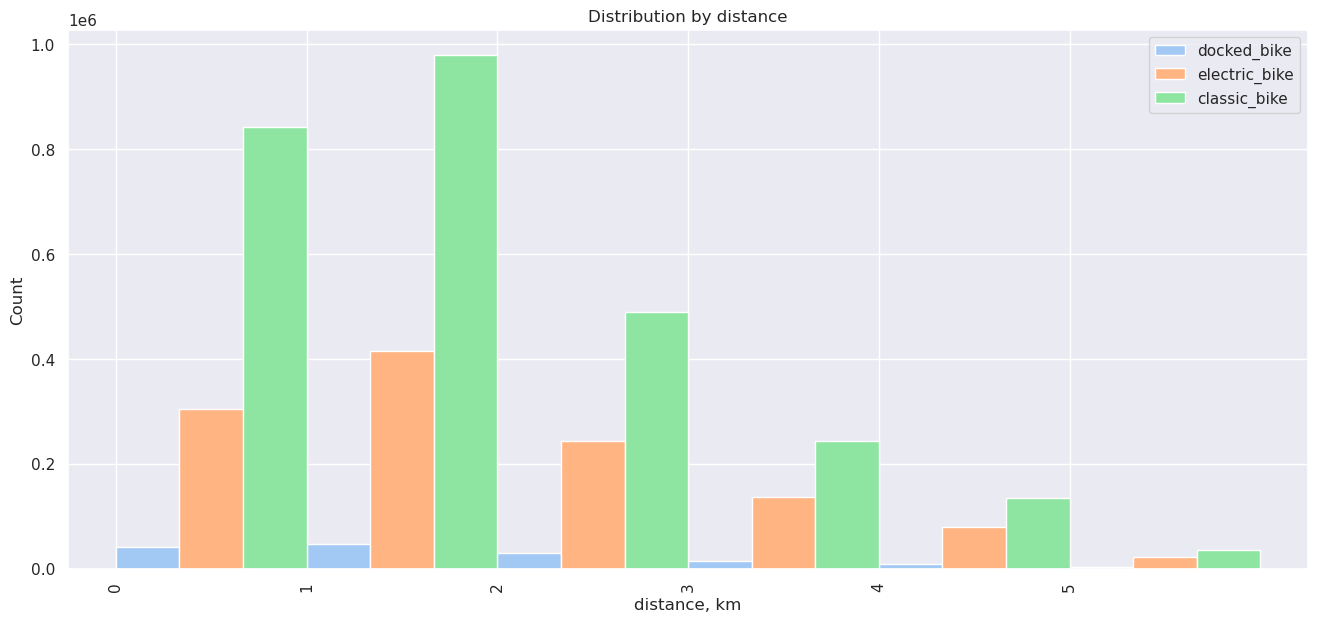

In [29]:
ax = dist_hist_2.plot.bar(
    x='hist', align='edge', width=1, 
    title='Distribution by distance',
    xlabel='distance, km', ylabel='Count',
    figsize=(16, 7), color=pastel,
)

Для каждого типа велосипедов по отдельности тренд сохраняется

---

Построим гистограмму распределения числа поездок по дням недели

In [30]:
day_hist = (
    plot_df.groupBy('day_of_week').count()
    .withColumn('sort', day_to_num('day_of_week'))
    .orderBy('sort').drop('sort').toPandas()
)

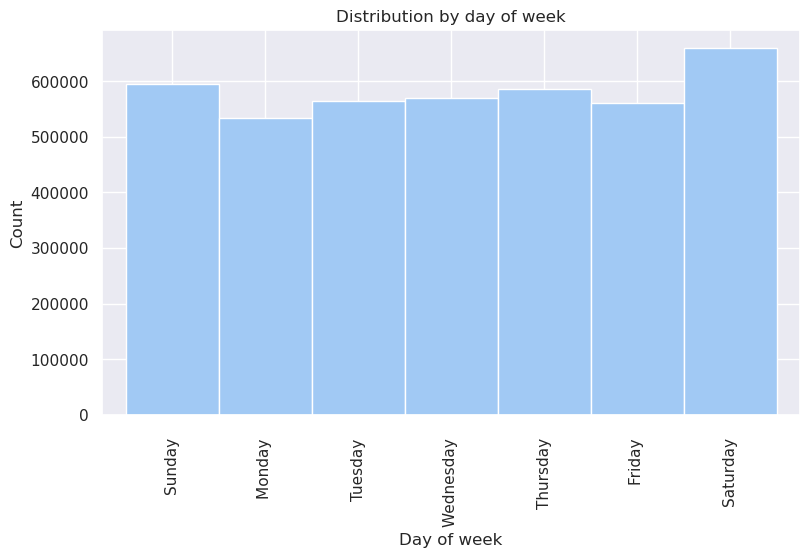

In [31]:
ax = day_hist.plot.bar(
    x='day_of_week', width=1, 
    title='Distribution by day of week',
    xlabel='Day of week', ylabel='Count',
    figsize=(9, 5), color=pastel,
)

ax.legend().remove()

Выходные дни имеют несколько большее число поездок, но разница не слишком большая

---

Построим распределение по месяцам

In [32]:
month = (
    plot_df.groupBy('month').count()
    .withColumn('sort', month_to_num('month'))
    .orderBy('sort').drop('sort').toPandas()
)

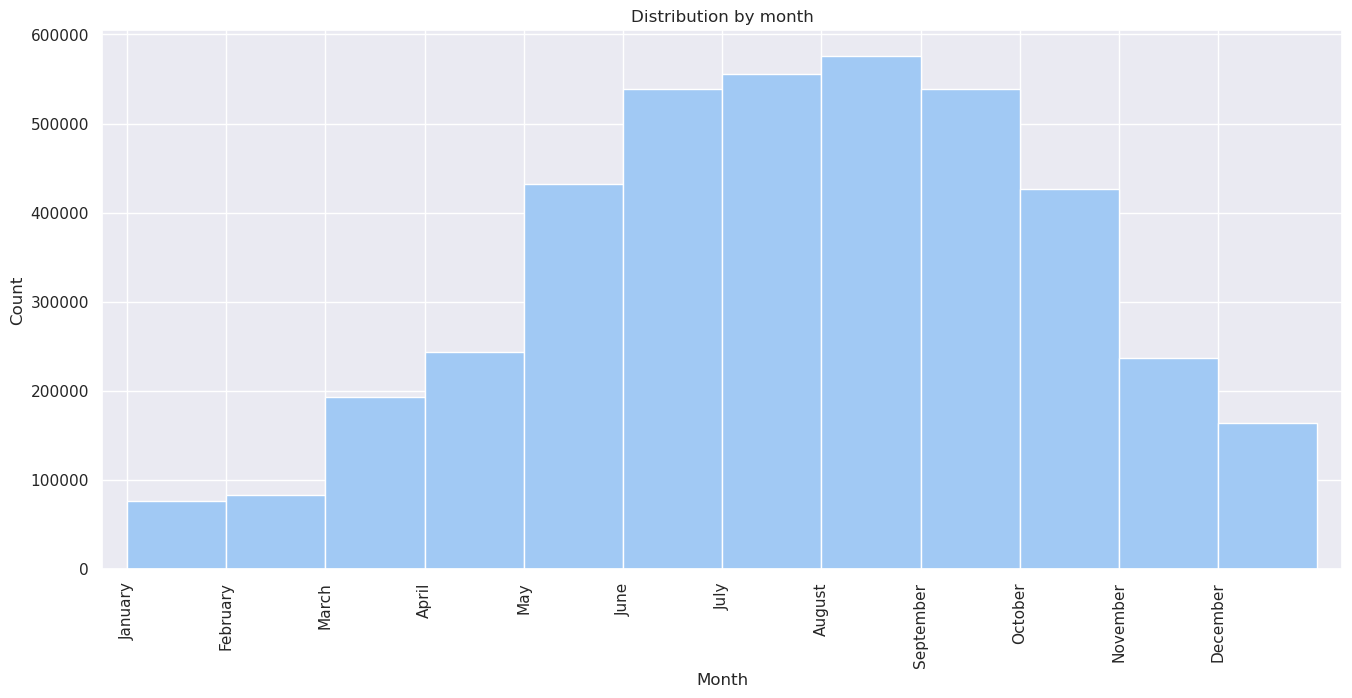

In [33]:
ax = month.plot.bar(
    x='month', align='edge', width=1, 
    title='Distribution by month',
    xlabel='Month', ylabel='Count',
    figsize=(16, 7), color=pastel,
)

ax.legend().remove()

Ожидаемо, в летние месяца велосипеды пользуются наибольшей популярностью

---

Отметим на карте координаты точек начала и завершения поездок из датасета. Выберем небольшой (10000) образец из датасета случайным образом.

Воспользуемся модулем geopandas для отображения на фоне очертаний города [Чикаго](https://www.kaggle.com/code/threadid/geopandas-mapping-chicago-crimes/data) (в котором собирались данные).

Затем отметим синими знаками `+` точки начала поездок, оранжевыми знаками `x` - точки окончания.

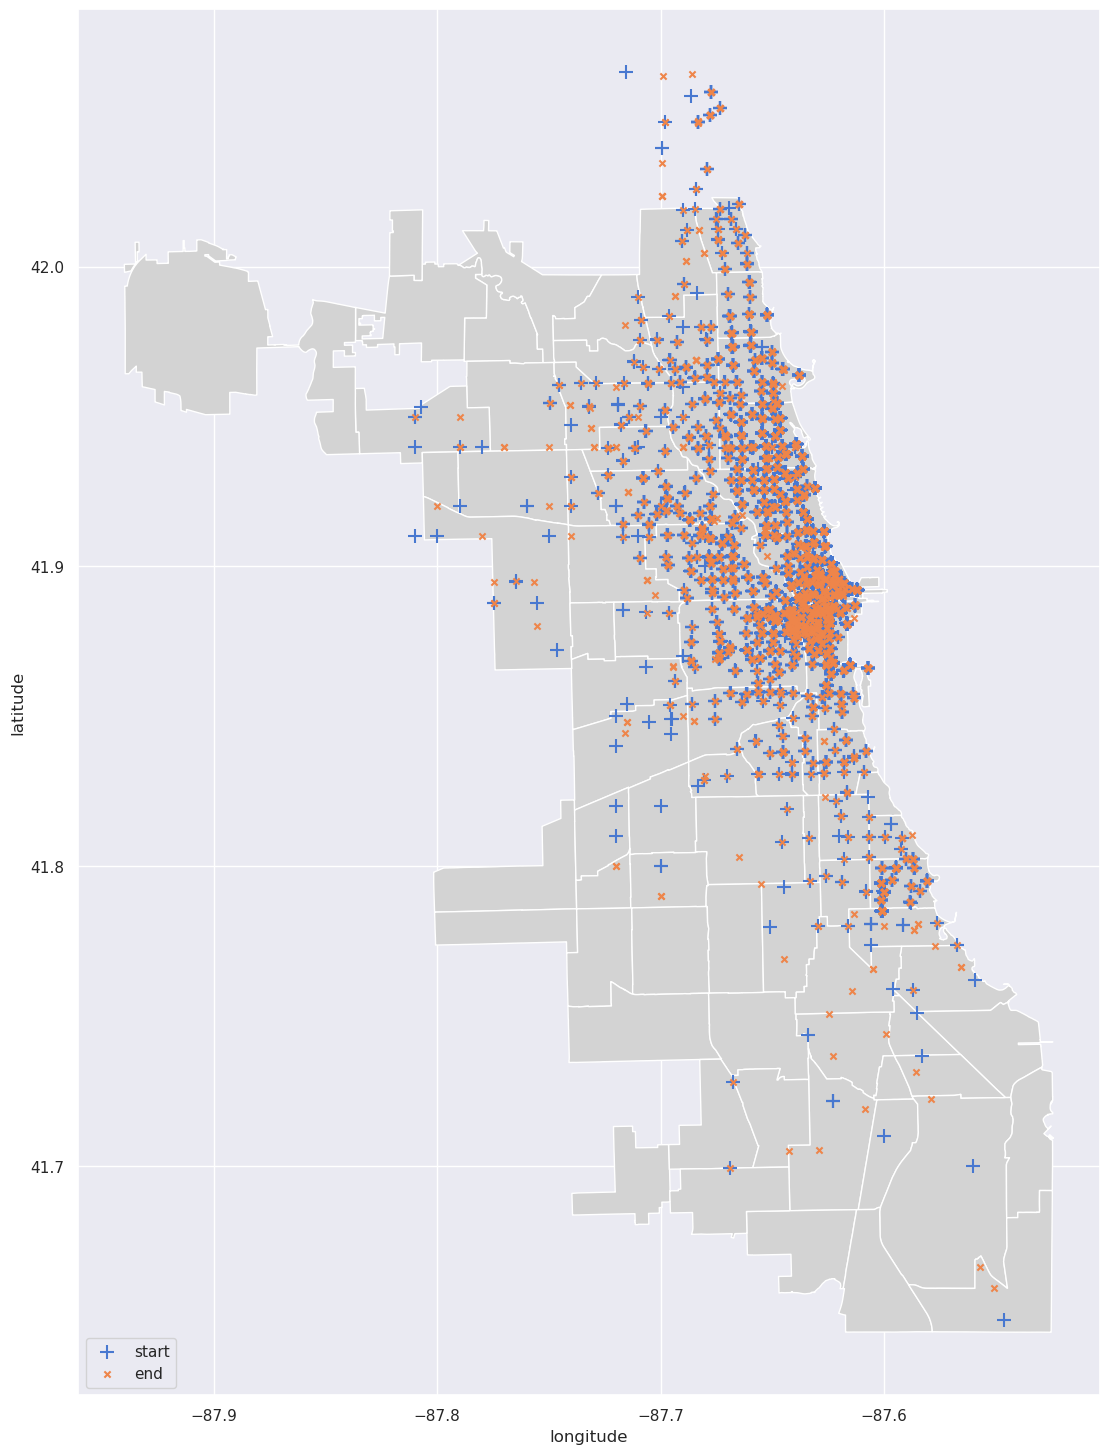

In [34]:
count = plot_df.count()
to_take = 10000

sample = plot_df.where(plot_df.round_trip == 0).sample(False, 10000 / count).limit(10000)

chicago = gpd.read_file('data/chicago/chicago.shp')
ax = chicago.plot(color="lightgrey", figsize=(24, 18))

ax = sample.select('start_lat', 'start_lng').toPandas().plot.scatter(
    x='start_lng', y='start_lat', ax=ax, label='start', color=[muted[0]], 
    marker='+', s=100)

ax = sample.select('end_lat', 'end_lng').toPandas().plot.scatter(
    x='end_lng', y='end_lat', ax=ax, label='end', color=[muted[1]],
    xlabel='longitude', ylabel='latitude', marker = 'x')

ax.legend(loc='lower left');

## Заключение

Таким образом, был проведён разведочный анализ датасета. Финальный датасет, получившийся после всех преобразований имеет следующий вид:

In [35]:
df.limit(5).toPandas()

,start_date,end_date,start_lat,start_lng,end_lat,end_lng,duration,day_of_week,month,distance,round_trip,electric_bike,docked_bike,member
0,2021-08-23 18:47:03,2021-08-23 19:00:08,41.929546,-87.643118,41.920771,-87.663712,785,Monday,August,1963.381209,0,0,0,1
1,2021-08-11 16:52:15,2021-08-11 17:21:23,41.871840,-87.646640,41.830629,-87.641290,1748,Wednesday,August,4603.825441,0,0,1,0
2,2021-08-08 17:09:02,2021-08-08 17:33:43,41.874754,-87.649807,41.880958,-87.616743,1481,Sunday,August,2823.031438,0,0,0,0
3,2021-08-26 18:37:23,2021-08-26 18:54:28,41.871737,-87.651030,41.880958,-87.616743,1025,Thursday,August,3018.261016,0,0,0,0
4,2021-08-21 10:20:20,2021-08-21 10:55:29,41.892278,-87.612043,41.880958,-87.616743,2109,Saturday,August,1317.484670,0,0,1,0


И имеет следующую схему:

In [36]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,start_date,timestamp
1,end_date,timestamp
2,start_lat,double
3,start_lng,double
4,end_lat,double
5,end_lng,double
6,duration,int
7,day_of_week,string
8,month,string
9,distance,double


Сохраним полученный датасет для дальнейшего использования

In [37]:
df.write.mode("overwrite").option("header", True).csv("data/prepared.csv")